In [6]:
import pandas as pd

In [7]:
alex_prices_5y = pd.read_csv("/kaggle/input/alex-areas/Alexandria Areas - 5Y.csv")
alex_prices_5y.loc[alex_prices_5y["Area"] == "Hay Sharq", "Area"] = "hay-sharq"

def clean_prices(price):
    return price.replace(',', '').split(" ")[1] if (len(price.split(" ")) > 1) else 0
years = alex_prices_5y.columns[2:]
for year in years:
    alex_prices_5y[year] = alex_prices_5y[year].apply(clean_prices)
    alex_prices_5y[year] = alex_prices_5y[year].astype(int)

In [8]:
alex_prices_2y = pd.read_csv("/kaggle/input/alex-areas/Alexandria Areas - 2Y.csv")

def clean_prices(price):
    return price.replace(',', '').split(" ")[1] if (len(price.split(" ")) > 1) else 0
years = alex_prices_2y.columns[2:]
for year in years:
    alex_prices_2y[year] = alex_prices_2y[year].apply(clean_prices)
    alex_prices_2y[year] = alex_prices_2y[year].astype(int)

In [9]:
alex_prices_1y = pd.read_csv("/kaggle/input/alex-areas/Alexandria Areas - 1Y.csv")

def clean_prices(price):
    return price.replace(',', '').split(" ")[1] if (len(price.split(" ")) > 1) else 0
years = alex_prices_1y.columns[2:]
for year in years:
    alex_prices_1y[year] = alex_prices_1y[year].apply(clean_prices)
    alex_prices_1y[year] = alex_prices_1y[year].astype(int)

In [10]:
alex_prices_5y = alex_prices_5y[alex_prices_5y["Bedrooms No."] > 1]
alex_prices_5y = alex_prices_5y[alex_prices_5y["Bedrooms No."] < 4]

alex_prices_2y = alex_prices_2y[alex_prices_2y["Bedrooms No."] > 1]
alex_prices_2y = alex_prices_2y[alex_prices_2y["Bedrooms No."] < 4]

alex_prices_1y = alex_prices_1y[alex_prices_1y["Bedrooms No."] > 1]
alex_prices_1y = alex_prices_1y[alex_prices_1y["Bedrooms No."] < 4]

In [11]:
years_5 = alex_prices_5y.columns[2:]
years_2 = alex_prices_2y.columns[2:]
years_1 = alex_prices_1y.columns[2:]
areas = list(set(alex_prices_5y["Area"]))
areas_df_list = []
for area in areas:
    # 5 years prices
    alex_prices_5y_recent = alex_prices_5y[alex_prices_5y["Area"] == area].T.loc[years_5]
    alex_prices_5y_recent_mean = alex_prices_5y_recent.T.mean().reset_index()
    
    alex_prices_5y_recent_mean.columns = ["Date", "Price Per Meter"]
    # alex_prices_5y_recent_mean = alex_prices_5y_recent_mean.iloc[:2]
    alex_prices_5y_recent_mean = alex_prices_5y_recent_mean.drop_duplicates(subset=["Price Per Meter"], keep='last')
    alex_prices_5y_recent_mean['Date'] = alex_prices_5y_recent_mean['Date'].astype(str) + 'Q4'
    alex_prices_5y_recent_mean = alex_prices_5y_recent_mean.rename(columns={alex_prices_5y_recent_mean.columns[1]: 'Price Per Meter'})
    
    # 2 years prices
    alex_prices_2y_recent = alex_prices_2y[alex_prices_2y["Area"] == area].T.loc[years_2]
    alex_prices_2y_recent_mean = alex_prices_2y_recent.T.mean().reset_index()
    alex_prices_2y_recent_mean.columns = ["Date", "Price Per Meter"]
    alex_prices_2y_recent_mean['Date'] = pd.to_datetime(alex_prices_2y_recent_mean['Date'], format='%b %Y')
    alex_prices_2y_recent_mean_q = alex_prices_2y_recent_mean.groupby(alex_prices_2y_recent_mean['Date'].dt.to_period('Q').astype(str))['Price Per Meter'].mean().reset_index()

    # 1 year prices
    alex_prices_1y_recent = alex_prices_1y[alex_prices_1y["Area"] == area].T.loc[years_1]
    alex_prices_1y_recent_mean = alex_prices_1y_recent.T.mean().reset_index()
    alex_prices_1y_recent_mean.columns = ["Date", "Price Per Meter"]
    alex_prices_1y_recent_mean['Date'] = pd.to_datetime(alex_prices_1y_recent_mean['Date'], format='%b %Y')
    alex_prices_1y_recent_mean_q = alex_prices_1y_recent_mean.groupby(alex_prices_1y_recent_mean['Date'].dt.to_period('Q').astype(str))['Price Per Meter'].mean().reset_index()
    
    area_prices = pd.concat([alex_prices_2y_recent_mean_q, alex_prices_5y_recent_mean], axis=0)
    area_prices = pd.concat([area_prices, alex_prices_1y_recent_mean_q], axis=0)

    area_prices_sorted = area_prices.sort_values(by='Price Per Meter', na_position='last')
    area_prices = area_prices_sorted.drop_duplicates(subset=['Date'], keep='first')
    area_prices = area_prices.sort_values(by='Date').reset_index(drop = True)
    area_prices = area_prices.rename(columns={area_prices.columns[1]: area})
    area_prices = pd.DataFrame({area: area_prices[area], "Date": area_prices["Date"]})
    areas_df_list.append(area_prices)
    area_prices_path = area + "-time-series.csv"
    area_prices.to_csv(area_prices_path)
    print(area_prices_path + " Saved")

hay-awal-el-montazah-time-series.csv Saved
alexandria-compounds-time-series.csv Saved
hay-sharq-time-series.csv Saved
hay-wasat-time-series.csv Saved
hay-than-el-montazah-time-series.csv Saved
hay-al-agami-time-series.csv Saved
hay-gharb-time-series.csv Saved
hay-el-gomrok-time-series.csv Saved
hay-al-amereyah-time-series.csv Saved


In [12]:
alex_prices = pd.concat(areas_df_list, axis=1)

alex_prices = alex_prices.loc[:, ~alex_prices.columns.duplicated()]

In [13]:
areas = alex_prices.drop(["Date"], axis=1).columns

In [14]:
macro = pd.read_csv("/kaggle/input/dat-macro-data/macroeconomics.csv", index_col=0)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import numpy as np

def impute_data(data):
    imp = IterativeImputer(max_iter=50, random_state=0)
    X = data.drop('Date', axis=1)
    prices_imputed = pd.DataFrame(imp.fit_transform(X), columns=X.columns)
    
    prices_imputed = np.clip(prices_imputed, 0, None)
    
    prices_imputed["Date"] = data["Date"]
    return prices_imputed

In [16]:
pd.merge(alex_prices, macro, on='Date', how='outer').drop_duplicates(subset=["Date"]).reset_index(drop=True).to_csv("ppm_missing.csv")

In [17]:
missing = pd.merge(alex_prices, macro, on='Date', how='outer').drop_duplicates(subset=["Date"]).reset_index(drop=True)

In [18]:
alex_prices["hay-gharb"] = alex_prices[['hay-gharb', 'hay-el-gomrok', 'hay-al-agami']].mean(axis=1)
alex_prices["hay-sharq"] = alex_prices[['hay-sharq', 'hay-awal-el-montazah', "hay-than-el-montazah", 'hay-wasat', "hay-el-gomrok"]].mean(axis=1)
alex_prices['hay-al-amereyah'] = alex_prices[['hay-al-amereyah', 'hay-al-agami', "hay-gharb", "hay-awal-el-montazah"]].mean(axis=1)
alex_prices['hay-than-el-montazah'] = alex_prices[['hay-than-el-montazah', "hay-awal-el-montazah"]].mean(axis=1)

In [19]:
import numpy as np
alex_ppm = pd.read_csv("/kaggle/input/ppm-alex/price_per_meter_2017_2024_v2.csv", index_col=0)
areas_df = []
date = []
for area in areas:
    alex_prices_to_impute = alex_prices[[area, "Date"]].replace(0, np.nan)
    areas_macro = pd.merge(alex_prices_to_impute, macro, on='Date', how='outer').drop_duplicates(subset=["Date"]).reset_index(drop=True)
    areas_macro = pd.merge(areas_macro, alex_ppm, on="Date", how="outer")
    prices_imputed = impute_data(areas_macro)
    areas_df.append(pd.Series(list(prices_imputed[area]), name=area))
    date = prices_imputed["Date"]

<ipython-input-19-b6948981c397>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  alex_prices_to_impute = alex_prices[[area, "Date"]].replace(0, np.nan)


In [20]:
combined_df = pd.concat(areas_df, axis=1)
combined_df["Date"] = date
combined_df.loc[:15, "hay-el-gomrok"] = 0

In [21]:
combined_df.loc[:15, "hay-el-gomrok"] = combined_df.iloc[:16][['hay-el-gomrok', 'hay-wasat', "hay-gharb"]].mean(axis=1)

In [22]:
combined_df.to_csv("ppm_2017_2024_areas_final_v3.csv")

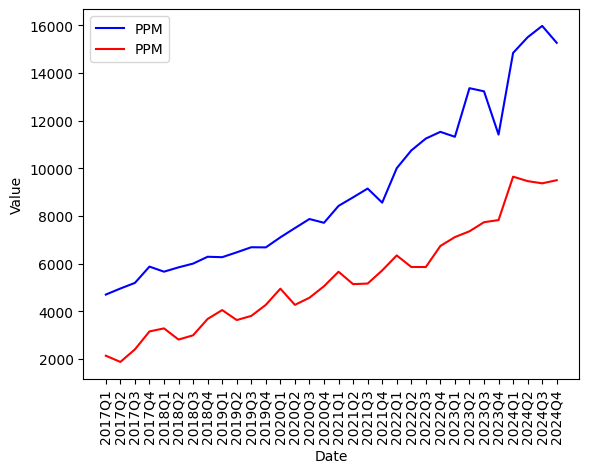

In [23]:
import matplotlib.pyplot as plt

# Plot both lines
combined_df["Date"] = combined_df["Date"].astype(str)
plt.plot(combined_df["Date"], combined_df["hay-al-amereyah"], label='PPM', color='blue')
plt.plot(combined_df["Date"], combined_df["hay-al-agami"], label='PPM', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=90)

# Add legend
plt.legend()

In [24]:
combined_df.describe()

,hay-awal-el-montazah,alexandria-compounds,hay-sharq,hay-wasat,hay-than-el-montazah,hay-al-agami,hay-gharb,hay-el-gomrok,hay-al-amereyah
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,8987.863698,23179.568851,11439.979316,13535.731627,10546.012486,5357.792509,12136.925300,10969.447977,9069.960133
std,2705.159079,4863.588519,3600.141763,3163.389078,2113.328148,2249.114426,3217.251304,6214.214758,3401.086550
min,5703.845698,18572.486993,6980.913887,9656.479335,8188.085208,1874.659945,8050.278696,5902.252677,4702.101849
25%,6832.864925,20257.612490,8747.990589,10988.357356,9012.681818,3667.913360,9454.962596,6949.125080,6284.853947
50%,8516.477125,21319.617868,10497.941451,13118.752703,10109.500000,5096.184247,11668.771995,7481.824091,8149.498957
75%,10450.000000,24005.188559,13277.574581,15661.525156,11373.821701,6835.375000,14309.458333,14623.066632,11348.947917
max,15758.000000,38432.000000,20215.875000,22102.500000,16915.000000,9651.000000,18407.166667,24931.000000,15979.687500


In [25]:
combined_df = combined_df.set_index(['Date'])

In [26]:
combined_df["hay-wasat"] = combined_df[['hay-wasat', 'hay-el-gomrok']].mean(axis=1)

In [ ]:
window_size = 5
combined_df['hay-al-amereyah'].rolling(window=window_size, center=True).mean()

In [ ]:
combined_df.reset_index().to_csv('ppm_2017_2024_areas_final_v8.csv')

In [ ]:
import seaborn as sns
g = sns.FacetGrid(combined_df, col='Area', col_wrap=4, height=4)
g.map(sns.histplot, 'Price Per Meter', kde=True)

In [ ]:
sns.boxplot(data=combined_df, x='Area', y='Price Per Meter')
plt.xticks(rotation=45)

In [ ]:
areas.append("Date")

In [ ]:
cols = ["hay-wasat", "Date", "hay-awal-el-montazah"]

In [ ]:
prices_imputed = prices_imputed[cols]

In [ ]:
prices_imputed

In [ ]:
prices_imputed['Date'] = pd.PeriodIndex(prices_imputed['Date'], freq='Q')

In [ ]:
import numpy as np

prices_imputed.loc[prices_imputed['Date'] < pd.Period('2020Q1', freq='Q'), 'hay-el-gomrok'] = np.nan

In [ ]:
prices_imputed.to_csv("areas_prices_2017_2024_2areas.csv")